感谢大家来我的网站学习https://www.captainbed.net

前面我们已经学习了Tensorflow1.x。现在我来带领大家学习Tensorflow2.x。

2.x与1.x已经大不相同了。我觉得这些变化的主要目的是让tensorflow更加简单易用。因为只有易用了，那么愿意使用的人才会多，市场占有率才大。为了让tensorflow变得更简单，让用户用得更爽，tensorflow的开发团队可谓是下了大功夫做了很多改动。就像我的教程一样，为了使教程变得更简单，我也是花了很多时间精力。

2.x的改动很大也很多，如果我赤裸裸地一窝蜂地列出来，即使你们每个字都能看懂，但你们也不能真正地理解它们。所以我下面会带大家一步一步地慢慢地逐个理解它们。当然，我不可能将改动全都讲到，那可能要花一本书的篇幅，我只会讲一些重要的，一些你们当前需要知道的。在后续的实战编程中，你们会自然而然地学到更多的2.x知识。

### Eager execution

还记得在前面我们学习1.x的时候，先要构建好计算图graph后，再用session来执行graph。如果你学过编程，你会觉得1.x的这种方式很奇怪。2.x终于将这种奇怪的方式给移除掉了。现在2.x的代码再也不需要session了，可以像编写普通python代码一样编写tensorflow代码了，代码在编写后就可以立即执行，不需要像1.x那样要等graph构建好了后再一起用session来执行了，2.x执行后的结果也会立即出现。这种机制在2.x中称为Eager execution，可以翻译成“饥饿执行”；之前1.x的机制被称为graph execution，也就是必须要构建好graph后才能执行。这里打一个不太恰当的比喻来帮助大家理解：eager execution就像搞一夜情，认识后就立即“执行”，而graph execution就像婚恋，认识后先憋着，不会立即“执行”，要经过了长时间的“积累”后，再一次性“执行”。

下面我将分别用1.x和2.x的方式来写同一段代码，帮助大家理解Eager execution。

In [33]:
# 因为我们安装的是tensorflow2.x，所以要想使用1.x代码的话，就需要使用下面的两行代码。
import tensorflow.compat.v1 as tfv1 # tfv1是1.x的tensorflow
# 你可能在此之前使用了tf.compat.v1.disable_eager_execution()，所以在此要重新开启eager模式。如果此句报错，那么请按左上角的按钮重启内核。
tfv1.compat.v1.enable_eager_execution() 

import numpy as np
import tensorflow as tf # tf是2.4的tensorflow

import timeit
from datetime import datetime

from tensorflow import keras
from tensorflow.keras import layers

In [34]:
# 这段代码是用1.x的方式写的
g = tfv1.Graph()
with g.as_default():
    y_hat = tfv1.constant(36, name='y_hat')           
    y = tfv1.constant(39, name='y')                        
    loss = tfv1.Variable((y - y_hat)**2, name='loss')              
    
with tfv1.Session(graph=g) as sess:
    init = tfv1.global_variables_initializer()
    sess.run(init)
    result = sess.run(loss)
    print(result)

9


In [35]:
# 这段代码是用2.x的方式写的
y_hat_2 = tf.constant(36)   
y_2 = tf.constant(39)                   

loss_2 = tf.Variable((y_2 - y_hat_2)**2)

print(loss_2.numpy())

9


通过上面两段代码的对比可以发现：

- 2.x的代码没有使用seesion就直接执行了

- 2.x的代码比1.x的代码简洁了很多，与python代码一样自然了。

### 引入了tf.function 

2.x的Eager模式有许多优点，例如代码简洁，还有就是能立即执行立即返回结果，从而使调式代码时也变得更轻松.....但是eager模式也有缺点，那就是代码的运行效率没有graph模式的高。因为graph模式是将大量操作构建成一个graph后再一致性执行的，所以执行效率要高。为了兼顾eager模式的开发便利和graph模式的运行高效，2.x引入了tf.function。通过tf.function可以将eager模式下的代码转换成graph模式，也就是说，我们在eager模式下编写代码然后在graph模式下运行代码。既然是将代码转化成graph，那为什么名字里使用function这个单词内，不应该是tf.graph吗？因为tf.function的作用就是将python function转化成包含了graph的tensorflow function。所以使用function这个单词也说得通。下面的代码可以帮助大家更好地理解。

In [36]:
# 定义一个 Python function.
def a_regular_function(x, y, b):
    x = tf.matmul(x, y)
    x = x + b
    return x

# `a_function_that_uses_a_graph` 是一个 TensorFlow `Function`.
a_function_that_uses_a_graph = tf.function(a_regular_function)

# 定义一些tensorflow tensors.
x1 = tf.constant([[1.0, 2.0]])
y1 = tf.constant([[2.0], [3.0]])
b1 = tf.constant(4.0)

orig_value = a_regular_function(x1, y1, b1).numpy()
# 在python中可以直接调用tenforflow Function。就像使用python自己的function一样。
tf_function_value = a_function_that_uses_a_graph(x1, y1, b1).numpy()

# eager模式下的执行结果与graph下的执行结果是一样的
assert(orig_value == tf_function_value)
print(orig_value)
print(tf_function_value)

[[12.]]
[[12.]]


是的！表面上看起来就是那么的平淡无奇。仅仅是在普通的函数外面套了一下tf.function。但是内部却发生了翻天覆地的变化，具体内部的变化我在这里就不说了，说了很多同学也不懂。同学们现在最好奇的应该是：套个tf.function就能提升执行效率啦？老师，我信你个鬼，你个死糟老头子。莫急莫急，真的是有很大提升的，不信你看下面的代码。

In [37]:
x = tf.random.uniform(shape=[10, 10], minval=-1, maxval=2, dtype=tf.dtypes.int32)

def power(x, y):
    result = tf.eye(10, dtype=tf.dtypes.int32)
    for _ in range(y):
        result = tf.matmul(x, result)
    return result
print("Eager execution:", timeit.timeit(lambda: power(x, 100), number=1000))

power_as_graph = tf.function(power)
print("Graph execution:", timeit.timeit(lambda: power_as_graph(x, 100), number=1000))

Eager execution: 7.22104665680672
Graph execution: 1.2193389385647606


同学，看到没有，上面的结果表明，同一段代码，在使用了tf.function后的graph模式下执行比要eager模型下快6倍！！老师没有骗你吧。

当然，这个速度与电脑性能也有关，也许在你的电脑上会有不同的值。另外具体计算的代码内容不同，效率的提升程度也是不同的。

tf.function不仅仅只作用于顶层的python function，它也作用于内嵌的python function。看下面的代码你就能明白了。

In [38]:
def inner_function(x, y, b):
    x = tf.matmul(x, y)
    x = x + b
    return x

# 使用tf.function将`outer_function`变成一个tensorflow `Function`。
# 注意，之前的代码是将tf.function当作是函数来使用，这样是被当作了修饰符来使用。这两种方式都是被支持的。
@tf.function
def outer_function(x):
    y = tf.constant([[2.0], [3.0]])
    b = tf.constant(4.0)

    return inner_function(x, y, b)

# tf.function构建的graph中不仅仅包含了 `outer_function`还包含了它里面调用的`inner_function`。
outer_function(tf.constant([[1.0, 2.0]])).numpy()

array([[12.]], dtype=float32)

更多关于tf.function的知识请看我csdn的文章https://blog.csdn.net/jiangjunshow/article/details/119908750

### 3种构建模型的方式

2.x中有3种构建模型的方式：Sequential model，Functional API，subclassing。下面我一个个给大家讲讲。

#### Sequential model方式

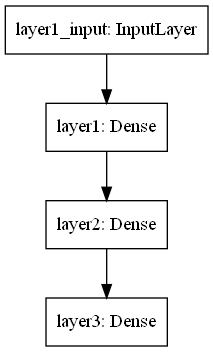

In [39]:
# 用Sequential model的方式构建一个模型
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = model(x)

# 打印出模型。
# 要执行这句需要安装一些东西：
# 1，在anaconda prompt里面执行activate tensorflow
# 2, 执行pip install pydot==1.4.2
# 3，去https://graphviz.gitlab.io/download/下载“2.49.0 EXE installer for Windows 10 (64-bit)”
# 4，下载后，安装graphviz，在安装时注意选择“Add Graphviz to the system PATH for all users"
# 5, 重启电脑
keras.utils.plot_model(model, "Sequential_model.png")

上面带代码就是用Sequential model的方式构建了一个模型。这种方式的最大优点是代码编写简单；最大缺点则是功能简单。有些模型无法用这种方式来构建，例如有多个输入的模型。下面介绍的functional API方式功能就要强大一些。下面我们用functional API的方式来构建一个拥有两个输入的模型。

注意：代码中的keras在tensorflow 1.x时是单独的一个框架，而2.x已经把keras融入到tensorflow里面了。

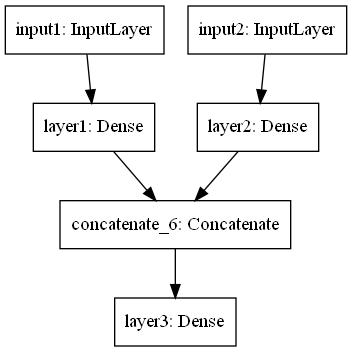

In [40]:
input1 = keras.Input(shape=(3,3), name="input1")  # Variable-length sequence of ints
input2 = keras.Input(shape=(3,3), name="input2")  # Variable-length sequence of ints
layer1 = layers.Dense(2,activation="relu", name="layer1")(input1)
layer2 = layers.Dense(2,activation="relu", name="layer2")(input2)
x = layers.concatenate([layer1, layer2])
layer3 = layers.Dense(4, name="layer3")(x)
model = keras.Model(
    inputs=[input1, input2],
    outputs=[layer3],
)
keras.utils.plot_model(model, "Functional API.png")

functional API方式已经能应付绝大多数的模型了。但依然无法构建某些模型，例如recursive networks递归网络模型和Tree RNNs。这时候我们需要使用subclassing方式。这种方式最大的一个缺点就是代码编写太复杂了。为了降低教程的复杂性，下面我只给大家演示用subclassing的方式来构建一个简单的模型。PS：如果直接构建一个recursive networks递归网络模型，大家看了后肯定就晕了。

In [41]:
# 这是用functional API方式构建的一个简单模型，后面我会用subclassing方式来构建一个同样的模型
inputs = keras.Input(shape=(32,))
x = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10)(x)
mlp = keras.Model(inputs, outputs)

In [42]:
# 这个就是subclassing方式，代码是比functional API方式复杂多了吧。
class MLP(keras.Model):
    def __init__(self, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.dense_1 = layers.Dense(64, activation='relu')
        self.dense_2 = layers.Dense(10)

    def call(self, inputs):
        x = self.dense_1(inputs)
        return self.dense_2(x)

# 实例化模型
mlp = MLP()
_ = mlp(tf.zeros((1, 32)))

那么有同学可能会问，到底哪种方式最好呢？应该用哪种方式呢？这类问题经常有同学问，例如哪种激活函数最好，哪种损失函数最好？我的回答依然是：它们都好。就像不同尺寸的螺丝，说不清楚谁好谁坏，只要用到了合适的螺母上面那就是最好的！

在后面的课程中，我们会用不同的方式来编写代码，以便让大家学得更多。当然，咱们的目的是教学，而不是开发商用产品，所以对于代码质量不会考虑太多，因为如果考虑太多细节，就会使代码变得复杂，不利于大家理解主要的理论知识。本教程主要是教大家人工智能知识，而不是教大家编程和高等数学！同学们要自己多花业余时间学习编程和数学知识！

另外需要注意的是，这3种构建模型的方式并不是互斥关系，它们是可以混合在一起使用的！看下面的代码。

In [43]:
units = 32
timesteps = 10
input_dim = 5

# 用Functional API的方式构建一个模型
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# 用subclassing的方式构建另一个模型
class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        # 在这里调用之前用Functional API构建的模型
        self.classifier = model

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

(1, 10, 32)


上面的代码将Functional API方式与subclassing方式混合在了一起。

2.x的知识点还很多很多，不可能一口气学完。今天咱们就先学到这，之后我会结合更加具体的实例来带领大家学习2.x。在学习实例的同时，自然而然地就能学到不少新的2.x的知识了！不提倡痛苦地学习，我们要轻松快乐地学习！